# Importing Data

In [174]:
# Install using "pip install surprise"
import numpy as np
import numba
import matplotlib.pyplot as plt
import sklearn.cluster
import sklearn.manifold

In [80]:
# Matrix factorization functions with bias
@numba.jit
def grad_U(Ui, Yij, Vj, ai, bj, reg, eta):
    """
    Takes as input Ui (the ith row of U), a training point Yij, the column
    vector Vj (jth column of V^T), reg (the regularization parameter lambda),
    and eta (the learning rate).

    Returns the gradient of the regularized loss function with
    respect to Ui multiplied by eta.
    """
    # Gradient with respect to Ui
    return eta*(reg*Ui-Vj*(Yij-(np.dot(Ui.T,Vj)+ai+bj)))

@numba.jit
def grad_V(Vj, Yij, Ui, ai, bj, reg, eta):
    """
    Takes as input the column vector Vj (jth column of V^T), a training point Yij,
    Ui (the ith row of U), reg (the regularization parameter lambda),
    and eta (the learning rate).

    Returns the gradient of the regularized loss function with
    respect to Vj multiplied by eta.
    """
    # Gradient with respect to Vj
    return eta*(reg*Vj-Ui*(Yij-(np.dot(Ui.T,Vj)+ai+bj)))

@numba.jit
def grad_a(Vj, Yij, Ui, ai, bj, reg, eta):
    """
    Takes as input the column vector Vj (jth column of V^T), a training point Yij,
    Ui (the ith row of U), reg (the regularization parameter lambda),
    and eta (the learning rate).

    Returns the gradient of the regularized loss function with
    respect to Vj multiplied by eta.
    """
    # Gradient with respect to Vj
    return eta*(reg*ai-(Yij-(np.dot(Ui.T,Vj)+ai+bj)))

@numba.jit
def grad_b(Vj, Yij, Ui, ai, bj, reg, eta):
    """
    Takes as input the column vector Vj (jth column of V^T), a training point Yij,
    Ui (the ith row of U), reg (the regularization parameter lambda),
    and eta (the learning rate).

    Returns the gradient of the regularized loss function with
    respect to Vj multiplied by eta.
    """
    # Gradient with respect to Vj
    return eta*(reg*bj-(Yij-(np.dot(Ui.T,Vj)+ai+bj)))

@numba.jit
def get_err(U, V, a, b, Y, reg=0.0):
    """
    Takes as input a matrix Y of triples (i, j, Y_ij) where i is the index of a user,
    j is the index of a movie, and Y_ij is user i's rating of movie j and
    user/movie matrices U and V.

    Returns the mean regularized squared-error of predictions made by
    estimating Y_{ij} as the dot product of the ith row of U and the jth column of V^T.
    """
    err = 0
    # Compute squared error   
    for p in range(0,len(Y)):
        # Convert indices counting from 0
        i=int(Y[p,0]-1)
        j=int(Y[p,1]-1)
        Yij=Y[p,2]
        err = err + (Yij-(np.dot(U[i],V[j])+a[i]+b[j]))**2
    # Return MSE + regularization
    return err/len(Y)/2+reg/2.0*(np.linalg.norm(U)**2+np.linalg.norm(V)**2+np.linalg.norm(a)**2+np.linalg.norm(b)**2)

@numba.jit
def train_model(M, N, K, eta, reg, Y, eps=0.0001, max_epochs=300):
    """
    Given a training data matrix Y containing rows (i, j, Y_ij)
    where Y_ij is user i's rating on movie j, learns an
    M x K matrix U and N x K matrix V such that rating Y_ij is approximated
    by (UV^T)_ij.

    Uses a learning rate of <eta> and regularization of <reg>. Stops after
    <max_epochs> epochs, or once the magnitude of the decrease in regularized
    MSE between epochs is smaller than a fraction <eps> of the decrease in
    MSE after the first epoch.

    Returns a tuple (U, V, err) consisting of U, V, and the unregularized MSE
    of the model.
    """
    # initial U and V to random floats from -0.5 to 0.5
    U = np.reshape(np.random.rand(M*K)-0.5,(M,K))
    V = np.reshape(np.random.rand(N*K)-0.5,(N,K))
    a = np.random.rand(M)-0.5
    b = np.random.rand(N)-0.5

    # Storage of U,V,err for each epoch
    data = []
    # For eps termination
    preverr = 100
    for epoch in range(0,max_epochs):
        # Shuffles the data before each epoch
        idx=np.random.permutation(np.arange(len(Y)))
        for p in idx:
            # Convert indices counting from 0
            i=int(Y[p,0]-1)
            j=int(Y[p,1]-1)
            Yij=Y[p,2]
            Ui = U[i]
            Vj = V[j]
            ai=a[i]
            bj=b[j]
            gradpick = np.random.randint(4)
            # Randomly update U, V, a, or b
            if gradpick==0:
                U[i]=U[i]-grad_U(Ui, Yij, Vj, ai, bj, reg, eta)
            elif gradpick==1:
                V[j]=V[j]-grad_V(Vj, Yij, Ui, ai, bj, reg, eta)
            elif gradpick==2:
                a[i]=a[i]-grad_a(Vj, Yij, Ui, ai, bj, reg, eta)
            else:
                b[j]=b[j]-grad_b(Vj, Yij, Ui, ai, bj, reg, eta)
        
        # Compute the error
        err = get_err(U,V,a,b,Y)
        data.append([U,V,err,a,b])
        if epoch%5==0:
            print('SGD on epoch ',epoch,', error=',err)
        # Terminate if error reduction is less than eps
        if abs(err-preverr) < eps:
            print('EPS condition reached')
            break
        preverr = err
    # Final output
    data=np.array(data)
    return data[-1,0],data[-1,1],data[-1,2],data[-1,3],data[-1,4]

Factorizing with  943  users,  1682  movies.
SGD on epoch  0 , error= 0.5171509739972913
SGD on epoch  5 , error= 0.4130491911069725
SGD on epoch  10 , error= 0.3951028283862699
SGD on epoch  15 , error= 0.3800265638841537
SGD on epoch  20 , error= 0.3649682879343385
SGD on epoch  25 , error= 0.3504863147031092
SGD on epoch  30 , error= 0.3376768253489094
SGD on epoch  35 , error= 0.3272324692700287
SGD on epoch  40 , error= 0.31940959558163345
SGD on epoch  45 , error= 0.3106936141975722
SGD on epoch  50 , error= 0.30371007968785657
SGD on epoch  55 , error= 0.29976174972574515
SGD on epoch  60 , error= 0.2947091981782053
SGD on epoch  65 , error= 0.29020953673832917
SGD on epoch  70 , error= 0.2860389945015893
SGD on epoch  75 , error= 0.2827489267285794
SGD on epoch  80 , error= 0.28047022426742335
EPS condition reached
CPU times: user 1min 34s, sys: 177 ms, total: 1min 34s
Wall time: 1min 34s


# Hyperparameter optimization

Optimize $\lambda$ while fixing $\kappa=20$

In [84]:
%%time
# Plotting code implementations for problem 2E
Y_train = np.loadtxt('./data/train.txt').astype(int)
Y_test = np.loadtxt('./data/test.txt').astype(int)

M = max(max(Y_train[:,0]), max(Y_test[:,0])).astype(int) # users
N = max(max(Y_train[:,1]), max(Y_test[:,1])).astype(int) # movies
K = 20

regs = np.linspace(0,0.5,11)
eta = 0.03 # learning rate

E_train = []
E_val = []
# Use to compute Ein and Eout
for reg in regs:
    print("Training model with M = %s, N = %s, k = %s, eta = %s, reg = %s"%(M, N, K, eta, reg))
    U,V,e_in,a,b = train_model(M, N, K, eta, reg, Y_train)
    E_train.append(e_in)
    eout = get_err(U, V, a, b, Y_test)
    E_val.append(eout)

E_train = np.array(E_train)
E_val = np.array(E_val)

Training model with M = 943, N = 1682, k = 20, eta = 0.03, reg = 0.0
SGD on epoch  0 , error= 0.8899776831163809
SGD on epoch  5 , error= 0.418682237699617
SGD on epoch  10 , error= 0.3404533018133693
SGD on epoch  15 , error= 0.2974226790160997
SGD on epoch  20 , error= 0.26759919198164417
SGD on epoch  25 , error= 0.24727975826097104
SGD on epoch  30 , error= 0.2316100324914726
SGD on epoch  35 , error= 0.22034057607573002
SGD on epoch  40 , error= 0.21156160968543028
SGD on epoch  45 , error= 0.20484100929100202
SGD on epoch  50 , error= 0.1991949875589976
SGD on epoch  55 , error= 0.19386596147442195
SGD on epoch  60 , error= 0.1899409200455928
SGD on epoch  65 , error= 0.18613509504005618
EPS condition reached
Training model with M = 943, N = 1682, k = 20, eta = 0.03, reg = 0.05
SGD on epoch  0 , error= 0.8959336189400984
SGD on epoch  5 , error= 0.42999498832378075
SGD on epoch  10 , error= 0.3667356756837063
SGD on epoch  15 , error= 0.32955391108197407
SGD on epoch  20 , error=

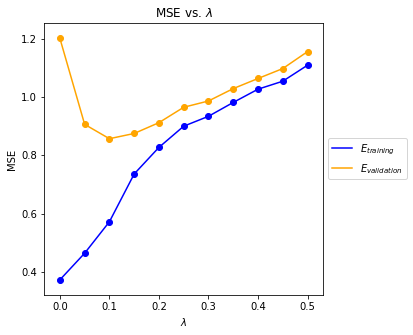

[0.   0.05 0.1  0.15 0.2  0.25 0.3  0.35 0.4  0.45 0.5 ]


In [92]:
# Plot values of E_in across k for each value of lambda
plt.figure(1,figsize=(5,5))
plt.plot(regs, 2*E_train, label='$E_{training}$',color='blue')
plt.scatter(regs, 2*E_train,color='blue')
plt.plot(regs, 2*E_val, label='$E_{validation}$',color='orange')
plt.scatter(regs, 2*E_val,color='orange')
plt.title('MSE vs. $\lambda$')
plt.xlabel('$\lambda$')
plt.ylabel('MSE')
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.savefig('MatrixFactorBias_hw.png',bbox_inches='tight')
plt.show()
print(regs)

# Training on Full Dataset, Getting Matrices

In [95]:
%%time
# Load data
Y_train = np.loadtxt('./data/train.txt').astype(float)
Y_test = np.loadtxt('./data/test.txt').astype(float)
full = np.loadtxt("./data/data.txt").astype(float)

M = max(max(Y_train[:,0]), max(Y_test[:,0])).astype(int) # users
N = max(max(Y_train[:,1]), max(Y_test[:,1])).astype(int) # movies
print("Factorizing with ", M, " users, ", N, " movies.")
K=20
reg = 0.1
eta = 0.03 # learning rate
# Normalize Yij
mu = np.mean(full[:,2])
Y_train[:,2]=Y_train[:,2]-mu
Y_test[:,2]=Y_test[:,2]-mu
full[:,2]=full[:,2]-mu
U,V,err,a,b = train_model(M, N, K, eta, reg, full)

Factorizing with  943  users,  1682  movies.
SGD on epoch  0 , error= 0.5107189223265607
SGD on epoch  5 , error= 0.4143302420483328
SGD on epoch  10 , error= 0.3968826475467027
SGD on epoch  15 , error= 0.3831082288178045
SGD on epoch  20 , error= 0.3685521640663981
SGD on epoch  25 , error= 0.3545985558005366
SGD on epoch  30 , error= 0.34427330784002136
SGD on epoch  35 , error= 0.334378182403154
SGD on epoch  40 , error= 0.32646804024794995
SGD on epoch  45 , error= 0.31847430233417895
SGD on epoch  50 , error= 0.31218690611211786
SGD on epoch  55 , error= 0.3076251515028566
SGD on epoch  60 , error= 0.3034644288338405
SGD on epoch  65 , error= 0.2997657590295742
EPS condition reached
CPU times: user 1min 33s, sys: 7.68 s, total: 1min 41s
Wall time: 1min 35s


# SVD and Projection

In [199]:
# Do SVD (singular value decomposition) on the matrices
A, Sigma, B = np.linalg.svd(V, full_matrices=False) # V = A @ np.diag(Sigma) @ B
# Get PCA representation of movie vector V
V_PCA = np.dot(A[0:2],V.T).T

print('Sigma of PCA')
print(Sigma)
print('Variability captured by top 2 components = ',(Sigma[0]+Sigma[1])/np.sum(Sigma))

Sigma of PCA
[15.0580125  11.99584437 11.74782539 11.375568   10.72637076 10.38816184
 10.17268156 10.0011504   9.83418231  9.55541668  9.38038055  9.30797157
  9.17081985  9.00633269  8.86181242  8.72695786  8.60792035  8.37749662
  8.16372654  7.94840489]
Variability captured by top 2 components =  0.13635532922088436


# Visualization

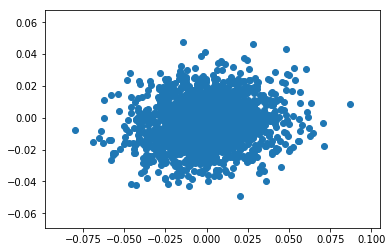

In [200]:
# Scatter the 2 dimensions of the reduced V
plt.scatter(V_PCA[:,0],V_PCA[:,1])
plt.show()

In [98]:
# Save factorization data
out = [U,V,err,a,b]
np.save('MatrixFactorBias_UVerr_ab',out)

In [115]:
class Movie():
    """ Object used to hold a Movie and its properties. """
    def __init__(self, idx, name, genres):
        self.idx = idx
        self.name = name
        self.genres = genres
        self.ratings = []
        self.n_ratings = 0
        self.avg_score = 0
    def add_rating(self, rating):
        """ Update the average rating by taking average * n_ratings = total score. Then add the new rating,
        and then divide by (n_ratings + 1) to get the new average. """
        self.avg_score = (self.avg_score * self.n_ratings + rating) / (self.n_ratings + 1)
        self.n_ratings += 1
        self.ratings.append(rating)
    def __repr__(self):
        return "Movie - Id: {0.idx}, Name: {0.name}, n_ratings = {0.n_ratings}, Avg score = {0.avg_score}".format(self)

In [134]:
# Dictionary that associates each movie ID to its movie object
movies = {}

# Read the list of movies and creates a dictionary of movie objects
with open("./data/movies.txt", "r", encoding="UTF8") as f:
    line = f.readline()
    
    # Split each line by the tab character. The 1st entry is the index, the 2nd entry is the name,
    # the 3rd entries onwards are the genres.
    while line != "":
        line = line.split("\t")
        # Convert the index to an int, convert the genres to a list of ints
        idx, name, genres = int(line[0]), line[1], line[2:]
        movies[idx] = Movie(idx, name, [int(x) for x in genres])
        
        line = f.readline()
        
# Read the ratings files and convert into a list of 3-tuples
def read_data(filename):
    with open(filename, "r") as f:
        data = f.readlines()
    # Split each line by the tab character and convert to a tuple of ints
    return [tuple(map(int, line.split("\t"))) for line in data]
       
full = read_data("./data/data.txt")

# Extract only the ratings from the full dataset
full_ratings = [datapt[2] for datapt in full]

# Go through the entire rating databast and add all the ratings for each movie
for rating_tuple in full:
    user_idx, movie_idx, rating = rating_tuple
    movies[movie_idx].add_rating(rating)

In [135]:
mgenres = np.array([movie.genres for movie in movies.values()])
# Do SVD (singular value decomposition) on the matrices
mA, mSigma, mB = np.linalg.svd(mgenres, full_matrices=False) # V = A @ np.diag(Sigma) @ B
# Get PCA representation of movie vector V
m_PCA = np.dot(mA[:2],mgenres.T).T
print(mSigma)

[28.59300977 22.18153542 19.06464919 14.40791409 14.133702   12.09654028
 10.13151284  9.5836941   9.18053786  8.55881923  8.06087928  7.4621318
  7.06666197  7.00471483  5.15024775  5.11922892  4.63635804  4.2848472
  1.41421356]


In [227]:
%%time
# Scatter the 2 dimensions of the reduced V
avgscores = np.array([movie.avg_score for movie in movies.values()])
nratings = np.array([movie.n_ratings for movie in movies.values()])
tsne=sklearn.manifold.TSNE(n_components=2,verbose=0,perplexity=30.0)
tgenres=tsne.fit_transform(mgenres)

CPU times: user 26.9 s, sys: 2.02 s, total: 28.9 s
Wall time: 29 s


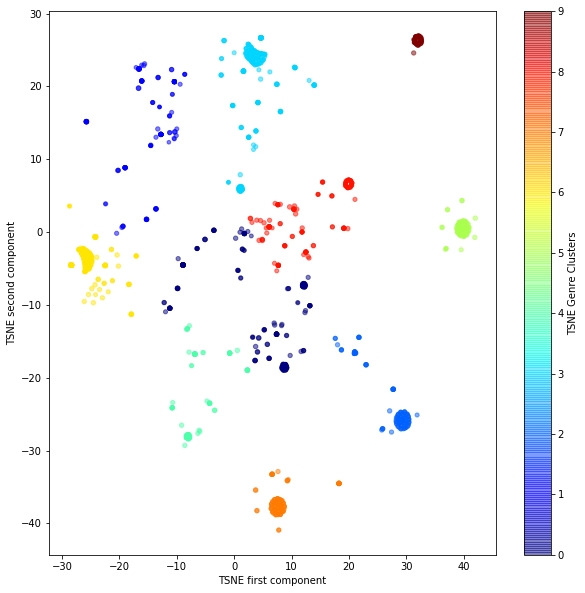

CPU times: user 645 ms, sys: 15.5 ms, total: 660 ms
Wall time: 659 ms


In [243]:
%%time
kmeans = sklearn.cluster.Birch(n_clusters=10)
kmeans.fit(tgenres)
clusters = kmeans.predict(tgenres)

plt.figure(1,figsize=(10,10))
plt.scatter(tgenres[:,0],tgenres[:,1],c=clusters,s=np.sqrt(avgscores)*10,cmap='jet',alpha=0.5)
plt.xlabel('TSNE first component')
plt.ylabel('TSNE second component')
plt.colorbar(label='TSNE Genre Clusters')
plt.savefig('TSNEcluster.png')
plt.show()

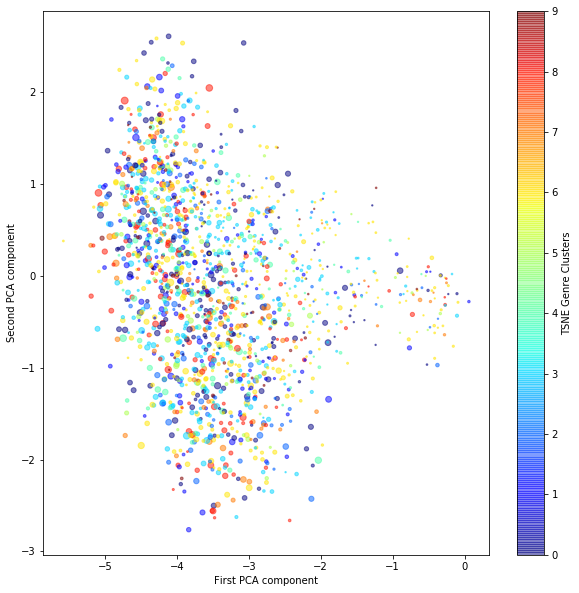

In [244]:
plt.figure(1,figsize=(10,10))
V_PCA=np.load('./data/V_red.npy').T
plt.scatter(V_PCA[:,0],V_PCA[:,1],c=clusters,s=np.sqrt(nratings)*2,cmap='jet',alpha=0.5)
plt.xlabel('First PCA component')
plt.ylabel('Second PCA component')
plt.colorbar(label='TSNE Genre Clusters')
plt.savefig('TSNE_PCA_cluster.png')
plt.show()